# FEM Modelling for STEDIN Transformer

The nonlinear magnetic characteristic with hysteresis neglected can be approximated as given in [1].
\begin{equation}
    \frac{1}{\mu} = k_1 e^{k_2B^2} + k_3
\end{equation}
where, $k_1$, $k_2$ and $k_3$ are constants equal to 3.8, 2.17, and 396.2, respectively.

[1] J. Brauer, “Simple equations for the magnetization and reluctivity curves of steel,” IEEE Transactions on Magnetics, vol. 11, no. 1, pp. 81–81, 1975.

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
include("../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../lib/FEM_Tri_1e.jl");
using .FEM_Tri_1e
include("../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../lib/Save_VTK.jl");
using .Save_VTK

## Julia code

In [7]:
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    v = k1 * exp(k2*B^2) + k3;
    return (1 ./ v)
end

gmsh.initialize()

## Read mesh from file
gmsh.open("../mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 0;       # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate current density in the windings
Jp = Np * Ip / Awhv;
Js = Ns * Is / Awlv;

# Source current density J
# One term for each of the windings, with a positive and negative part
# Note the phase shift between the phases
sourcefunction(group_id) = Jp * exp(1im * 2pi/3) * (-1 * (group_id==3) + 1 * (group_id==4)) + 
                           Jp * (-1 * (group_id==5) + 1 * (group_id==6)) + 
                           Jp * exp(-1im * 2pi/3) * (-1 * (group_id==7) + 1 * (group_id==8)) + 
                           Js * exp(1im * 2pi/3) * (1 * (group_id==9) - 1 * (group_id==10)) +
                           Js * (1 * (group_id==11) - 1 * (group_id==12)) + 
                           Js * exp(-1im * 2pi/3) * (1 * (group_id==13) - 1 * (group_id==14));
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2000;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

mur_pts = findall(x->x==2, mesh_data.e_group)
L = LinearIndices(mesh_data.e_group)
mur_pts = L[mur_pts]
    
## Threshold value for the error
threshold = 1e-6 .* ones(length(mur_pts))

Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

for loop = 1:10000
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids);

    # Post-process for magnetic field and current density
    Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement);

    ## Check the error with the threshold values
    if abs.((1 ./ mu_func.(abs.(B[mur_pts]))) - reluctivityperelement[mur_pts]) <= threshold
        break;
    end

    ## Assign new value of mur
    reluctivityperelement[mur_pts] = 1 ./ mu_func.(abs.(B[mur_pts]));
end

# Contour plot of the magnetic flux density
plot_surface_tri_1e(norm.(B), "stedin_transformer_B_plot_nonlinear", gmsh)
# Contour plot of the magnetic field strength
plot_surface_tri_1e(norm.(H), "stedin_transformer_H_plot_nonlinear", gmsh)
# Contour plot of the magnetic energy
plot_surface_tri_1e(norm.(mag_energy), "stedin_transformer_mag_energy_plot_nonlinear", gmsh)

# Save as VTK file for Paraview visualization
save_vtk(mesh_data, norm.(u), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, "stedin_transformer_nonlinear")

gmsh.finalize()

Info    : Reading '../mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../mesh/stedin_transformer.msh'


"Done"

LoadError: SingularException(0)

### STEDIN Transformer : Magnetic field density
<img src="../img/stedin_transformer_B_plot_nonlinear.png">

### STEDIN Transformer : Magnetic field strength
<img src="../img/stedin_transformer_H_plot_nonlinear.png">

### STEDIN Transformer : Magnetic energy
<img src="../img/stedin_transformer_mag_energy_plot_nonlinear.png">

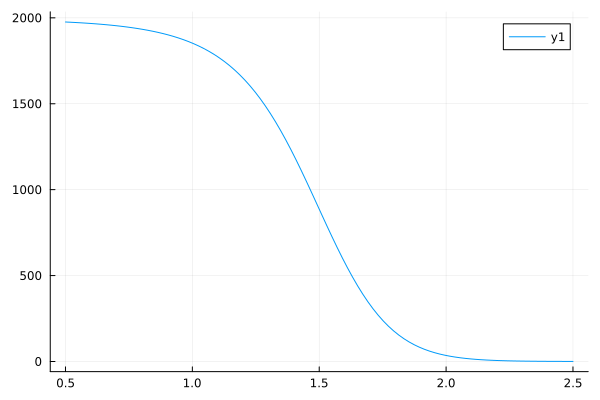

In [3]:
# Plot of mu vs B
using Plots

B = collect(range(0.5, 2.5, 100))
plot(B,mu_func.(B)/mu0)